In [1]:
#!/usr/bin/env python
# coding: utf-8

import sys, platform, os
import numpy as np
import camb
import pandas as pd
import healpy as hp
from camb import model, initialpower
import useful_functions as uf
import pysm3
from fgbuster import (CMB, Dust, Synchrotron, basic_comp_sep,get_observation, get_instrument)
from fgbuster.visualization import corner_norm
home_dir="/home/amorelli/foreground_noise_maps/"
seed_test=70
np.random.seed(seed_test)# i set a seed for the generation of the maps and the a_lm. I use a seed for reproducibility.

n_maps=1
n_channels=2
pol=2

instrument = get_instrument('LiteBIRD')
sensitivities=instrument["depth_p"]

n_freq=len(sensitivities)
nside=16
n_pix=hp.nside2npix(nside)

sync_file=home_dir+"d0s0_file.npz"
#sync_file=home_dir+"d0s0_file.npz"
npzfile = np.load(sync_file)
sync_freq_maps=npzfile['sync_freq_maps']

r=np.ones(1)*0.01
data=uf.generate_cl(n_spectra=1,Nside=512,Nside_red=nside,tau_interval=[0.06,0.06],r_interval=[0.01,0.01], raw=False)

beam_w=2*hp.nside2resol(nside, arcmin=False)

components = [CMB(), Dust(150.), Synchrotron(20.)]

noise_maps=np.ones(shape=(n_freq,n_maps,n_pix,n_channels*pol))
#noise_maps_T=np.ones(shape=(n_freq,n_maps,n_pix))
for i,s in enumerate(sensitivities):
    corr=np.sqrt(2)
    noise=uf.generate_noise_maps(n_maps,n_channels,nside,pol=2,sensitivity=s*corr)#if i consider half of the execution time the error increases
    #you can prove it using S/N formula
    #noise_T=uf.generate_noise(n_maps,s*corr/np.sqrt(2),nside)
    noise_maps[i]=noise
    #noise_maps_T[i]=noise_T

noise=noise_maps[0]*0.0

maps_per_cl_gen=uf.maps_per_cl(distribution=0)
maps_per_cl=maps_per_cl_gen.compute_maps_per_cl(r,n_train=n_maps,n_train_fix=n_maps)

QU_maps=uf.generate_maps(data=data, r=r,n_train=n_maps,nside=16, map_per_cl=maps_per_cl, noise_maps=noise, beam_w=beam_w, kind_of_map="QU", raw=1, n_channels=2, beam_yes=1 , verbose=0)[0]
#T_maps=uf.generate_maps(data=data, r=r,n_train=n_maps,nside=16, n_train_fix=0, 
                        #beam_w=beam_w, kind_of_map="TT", raw=1 , distribution=0, n_channels=1, 
                        #sensitivity=0,beam_yes=1 , verbose=0)[0]

freq_maps=np.ones(shape=(n_channels,n_maps,n_freq,pol,n_pix)) #comp_sep wants n_channels as first dimension, also i cannot
#put polarization in the n_channel dimension -> i break my conventions
#freq_maps=np.ones(shape=(n_maps,n_freq,3,n_pix))
for i in range(n_maps):
    for j in range(n_freq):
        # freq_maps[j,i,0]=noise_maps_T[i,j]+sync_freq_maps[i,0]+T_maps[j,:,0]
        # freq_maps[j,i,1]=noise_maps[i,j]+sync_freq_maps[i,1]+QU_maps[j,:,0]
        # freq_maps[j,i,2]=noise_maps[i,j]+sync_freq_maps[i,2]+QU_maps[j,:,1]
        for k in range(n_channels):
            freq_maps[k,i,j,0,:]=noise_maps[j,i,:,k*n_channels]+sync_freq_maps[j,1]+QU_maps[i,:,k*n_channels]
            freq_maps[k,i,j,1,:]=noise_maps[j,i,:,k*n_channels+1]+sync_freq_maps[j,2]+QU_maps[i,:,k*n_channels+1]

result = np.ones(shape=(n_maps,n_pix,n_channels*pol))
import time
start_time = time.time()
#result = np.ones(shape=(n_maps,3,n_pix))
for i in range(n_maps):
    for k in range(n_channels):
        compsep=basic_comp_sep(components, instrument, freq_maps[k,i]).s[0]
        for p in range(pol):
            result[i,:,k*pol+p]=compsep[p]-QU_maps[i,:,k*pol+p]
print("--- %s seconds ---" % (time.time() - start_time))

/home/amorelli/fgbuster/fgbuster/observation_helpers.py:97: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  return df.dropna(1, 'all')


--- 0.9059076309204102 seconds ---


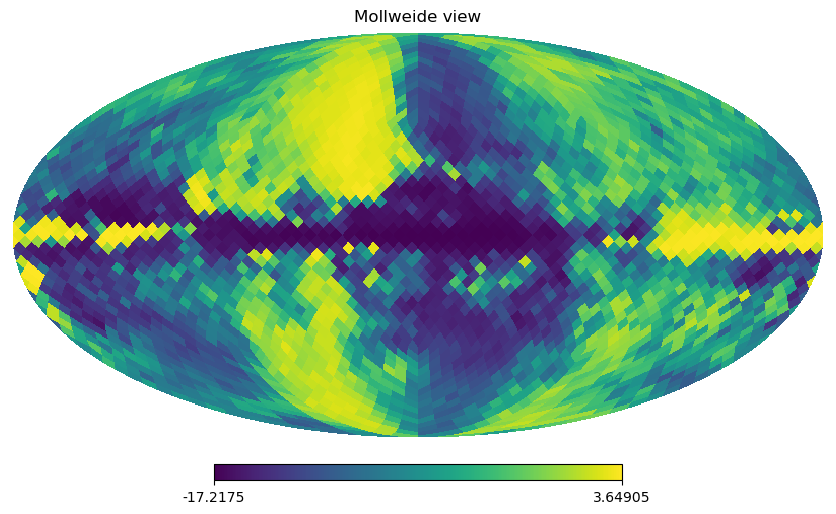

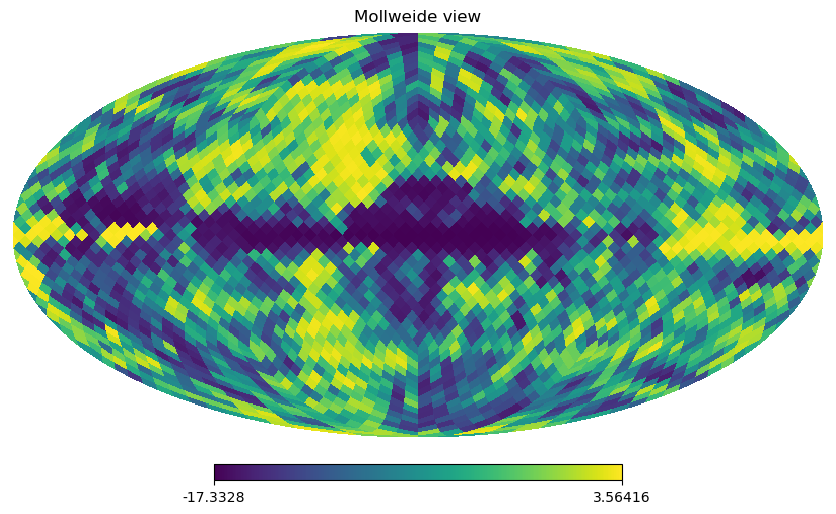

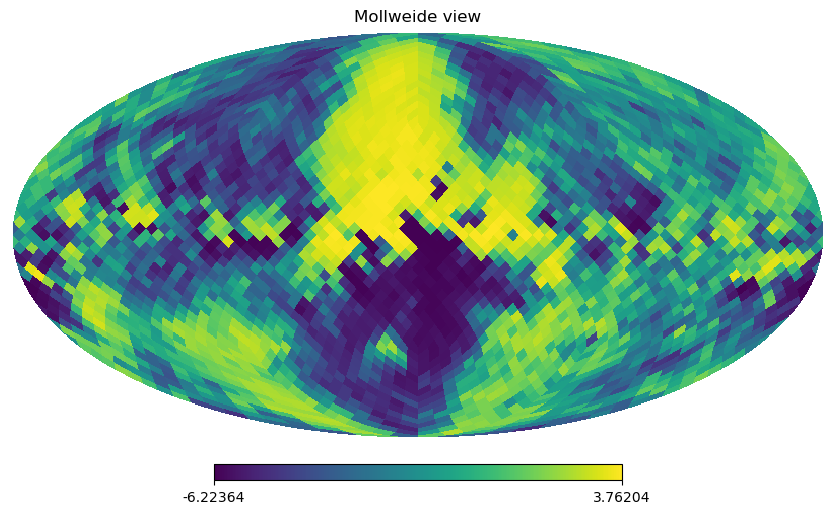

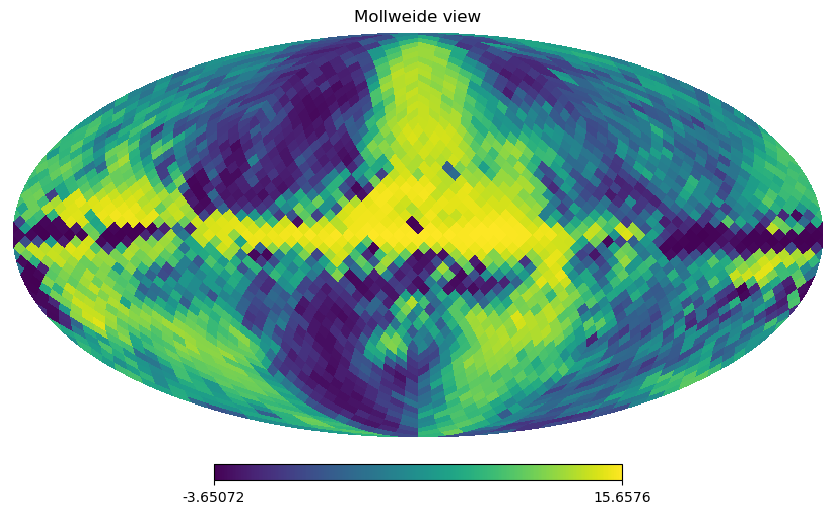

In [2]:
hp.mollview(result[0,:,0],norm="hist")#,min=-1.5,max=1.5)
hp.mollview(QU_maps[0,:,0]+result[0,:,0],norm="hist")#,min=-1.5,max=1.5)
hp.mollview(result[0,:,1],norm="hist")
hp.mollview(result[0,:,1]-result[0,:,0],norm="hist")

In [3]:
res=hp.nside2resol(nside, arcmin=True)
mean_Q=np.mean(result[0,:,0])
std_Q=np.std(result[0,:,0])
sensitivity_Q=std_Q*res
print(mean_Q,std_Q,sensitivity_Q)

-0.24776892393275918 0.9863095687682474 216.86099976632315


In [4]:
mean_U=np.mean(result[0,:,1])
std_U=np.std(result[0,:,1])
sensitivity_U=std_U*res
print(mean_U,std_U,sensitivity_U)

0.023520056007118362 0.39237504468191503 86.27194459782186


In [5]:
E_maps, B_maps = uf.convert_to_EB(result)

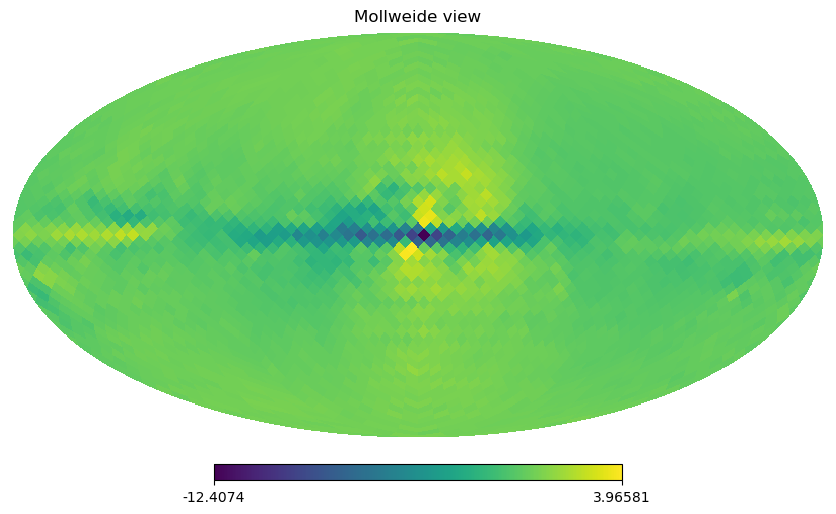

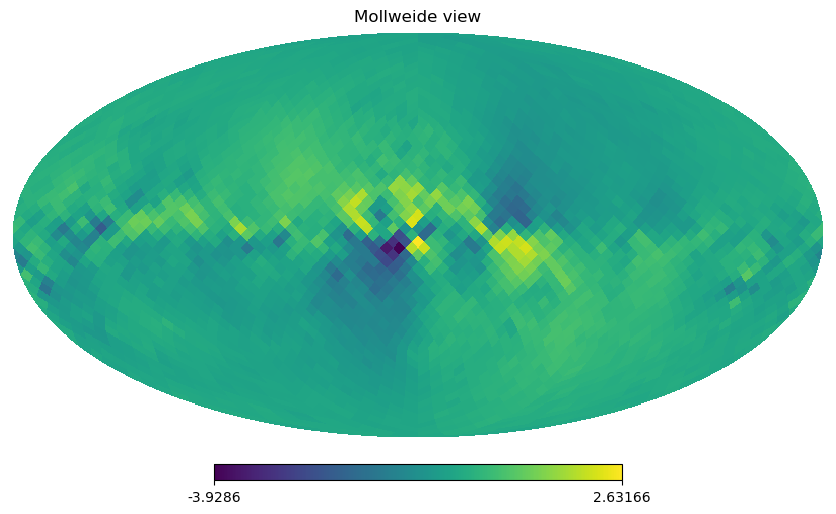

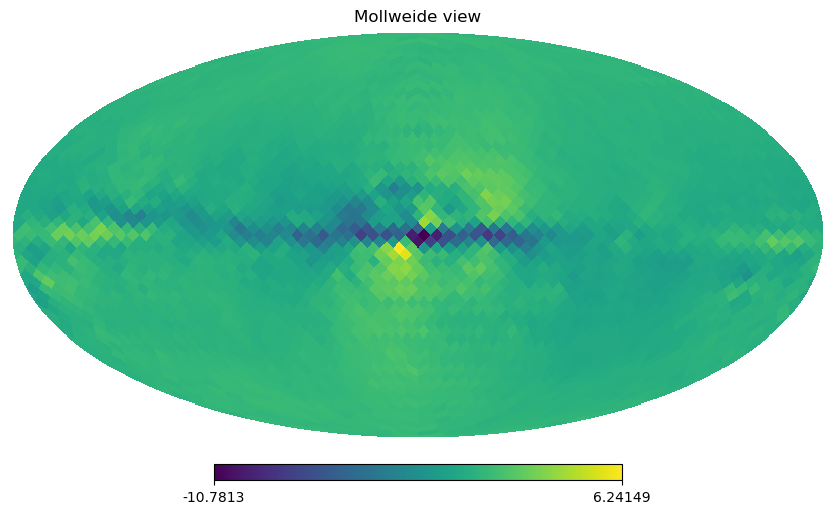

In [6]:
hp.mollview(E_maps[0,:,0])
hp.mollview(B_maps[0,:,0])
hp.mollview(E_maps[0,:,0]-B_maps[0,:,0])

In [7]:
mean_E=np.mean(E_maps[0,:,0])
std_E=np.std(E_maps[0,:,0])
sensitivity_E=std_E*res
print(mean_E,std_E,sensitivity_E)

-0.00013306989659150892 0.9526621425904668 209.4629021390339


In [8]:
mean_B=np.mean(B_maps[0,:,0])
std_B=np.std(B_maps[0,:,0])
sensitivity_B=std_B*res
print(mean_B,std_B,sensitivity_B)

2.0316873458029832e-05 0.4892924599414253 107.58128624214265


In [9]:
pol=2
n_maps, n_pix, n_channels = (result.shape[0],result.shape[1],int(result.shape[2]/pol))
nside=hp.npix2nside(n_pix)
#print(n_maps,n_pix,nside,n_channels)
result_2=np.empty_like(result)
mappe_placeholder=np.zeros((n_maps,n_pix))
for i in range(n_maps):
    for k in range(n_channels):
        alm=hp.map2alm([mappe_placeholder[i,:],result[i,:,k*pol],result[i,:,k*pol+1]], pol=True, verbose=True)
        mappp, result_2[i,:,k*n_channels],result_2[i,:,k*n_channels+1]=hp.alm2map(alm, nside, pol=True, verbose=True)

In [10]:
mean_Q2=np.mean(result_2[0,:,0])
std_Q2=np.std(result_2[0,:,0])
sensitivity_Q2=std_Q2*res
print(mean_Q2,std_Q2,sensitivity_Q2)

-0.24785665325133222 0.9666458447523871 212.53751453994136


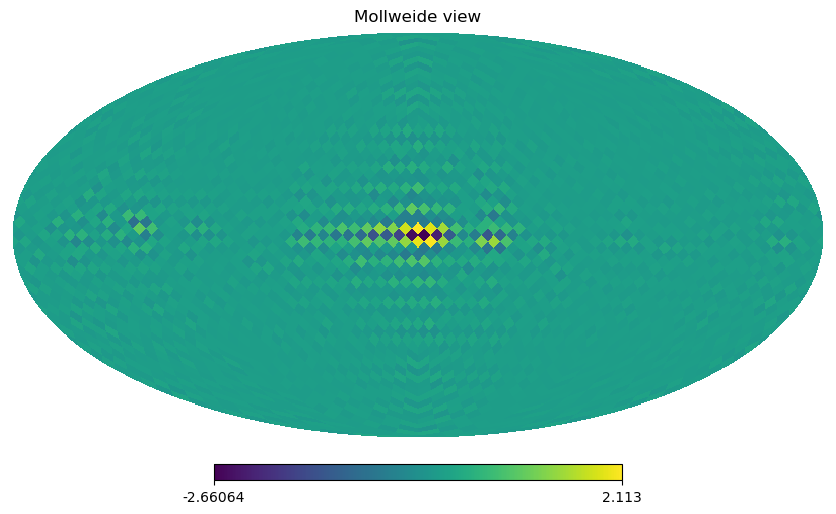

In [11]:
hp.mollview(result[0,:,0]-result_2[0,:,0])

In [12]:
beam_w=0.01*hp.nside2resol(nside, arcmin=False)
lmax=len(data[0,0,:])
print(lmax)
beam=hp.gauss_beam(beam_w, lmax=lmax)
pol=2
result_3=np.empty_like(result)
for i in range(n_maps):
    for k in range(n_channels):
        alm=hp.map2alm([mappe_placeholder[i,:],hp.smoothing(result[i,:,k*pol],fwhm=beam_w)
                        ,hp.smoothing(result[i,:,k*pol+1],fwhm=beam_w)]
                        , pol=True, verbose=True)
        #alm_wb = np.array([hp.almxfl(each,beam) for each in alm]) #i multiply the alm by the window functions
        mappp, result_3[i,:,k*n_channels],result_3[i,:,k*n_channels+1]=hp.alm2map(alm, nside, pol=True, verbose=True)

47


In [13]:
mean_Q3=np.mean(result_3[0,:,0])
std_Q3=np.std(result_3[0,:,0])
sensitivity_Q3=std_Q3*res
print(mean_Q3,std_Q3,sensitivity_Q3)

-0.24784130919152036 0.9665606713615779 212.51878737022784


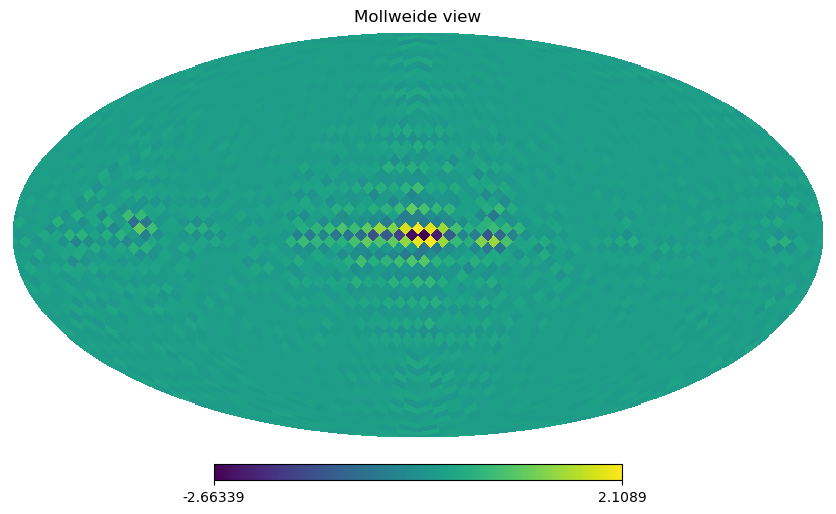

In [14]:
hp.mollview(result[0,:,0]-result_3[0,:,0])

In [15]:
pol=2
result_4=np.empty_like(result)
mappe_placeholder=np.zeros((n_maps,n_pix))
for i in range(n_maps):
    for k in range(n_channels):
        cl=hp.anafast([hp.remove_monopole(mappe_placeholder[i,:]),
                           hp.remove_monopole(result[i,:,k*pol]),hp.remove_monopole(result[i,:,k*pol+1])],lmax=lmax-1,pol=True)
        alm= hp.synalm((cl[0], cl[1], cl[2], cl[3]), lmax=lmax, new=True)
        mappp, result_4[i,:,k*n_channels],result_4[i,:,k*n_channels+1]=hp.alm2map(alm, nside, pol=True, verbose=True)

In [16]:
mean_Q4=np.mean(result_4[0,:,0])
std_Q4=np.std(result_4[0,:,0])
sensitivity_Q4=std_Q4*res
print(mean_Q4,std_Q4,sensitivity_Q4)

0.21509113343814357 0.684577399066338 150.51880654910119


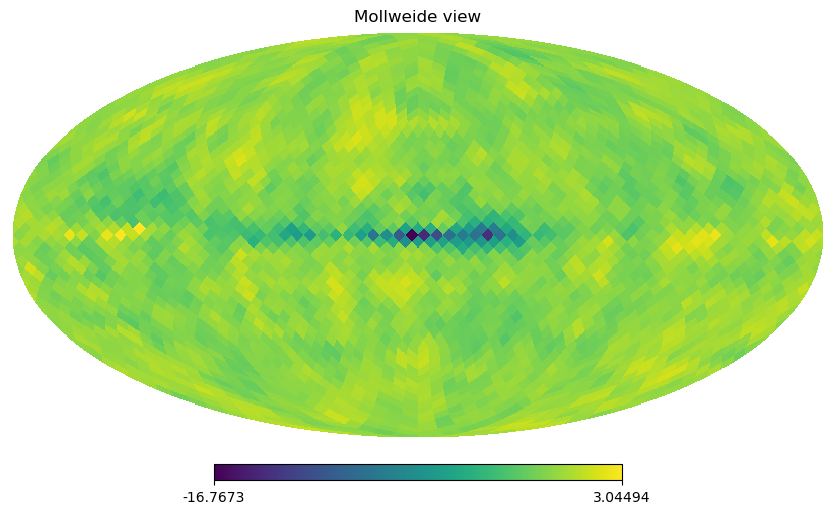

In [17]:
hp.mollview(result[0,:,0]-result_4[0,:,0])